In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import sqrt

import DataAid
import Neros

In [10]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

## Create the Milky Way interpolation function

In [27]:
MW_rad = MWXueSofue[:,0]
MW_Vlum = MWXueSofue[:,1]
# Interpolation function
MW_Vlum_interp_func = interp1d(MW_rad, MW_Vlum, kind='cubic', fill_value="extrapolate")

## Test on a single galaxy

In [25]:
NGC5371 = np.array(sparcGalaxies['NGC5371_rotmod'])
NGC5371_rad = NGC5371[:,0]
NGC5371_Vobs = NGC5371[:,1]
NGC5371_gas = NGC5371[:,3]
NGC5371_disk = NGC5371[:,4]
NGC5371_bulge = NGC5371[:,5]
NGC5371_VlumSquared = Neros.VlumSquared(NGC5371_gas, NGC5371_disk, NGC5371_bulge)
NGC5371_Vlum = np.sqrt(NGC5371_VlumSquared)
Vlcm = Neros.Vlcm(NGC5371_rad, MW_Vlum_interp_func(NGC5371_rad), NGC5371_Vlum )
print("Vlcm: ")
print(Vlcm)

Vlcm: 
[   2.92036417   21.56904928   46.66408505   75.20792304  109.20623884
  143.62762747  223.75059785  344.55957711  509.67729663  692.61803946
  905.13742597 1158.53661405 1412.564305   1662.75277186 1897.05555782
 2147.92779984 2380.89674326 2597.93035107 2800.7878094 ]


ValueError: A value in x_new is above the interpolation range.

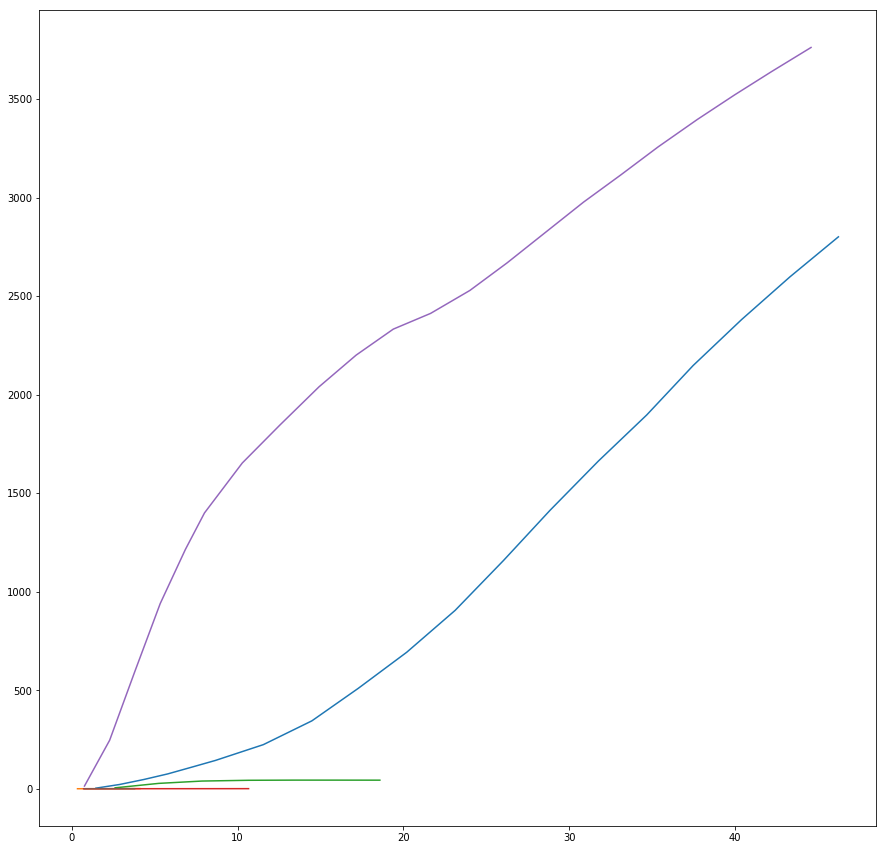

In [26]:
VlcmList = []
f, ax = plt.subplots(1, figsize=(15,15))
for galaxyName in sparcGalaxies:
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_Vobs = galaxy[:,1]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_VlumSquared = Neros.VlumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_Vlum = np.sqrt(galaxy_VlumSquared)
    Vlcm = Neros.Vlcm(galaxy_rad, MW_Vlum_interp_func(galaxy_rad), galaxy_Vlum )
    VlcmList.append(Vlcm)
    # plot
    ax.plot(galaxy_rad, Vlcm, label=galaxyName)
ax.legend(loc="upper right")

In [ ]:
# Testing eTsi
